## Electricity price prediction for NYC

In [47]:
import pandas as pd

import numpy as np
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
import datetime as dt
import time

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
#from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D
from keras.callbacks import Callback

In [54]:
df_price = pd.read_csv('nyiso_price_2017.csv', parse_dates=['time_stamp', 'time_stamp_local'])
df_load = pd.read_csv('nyiso_load_2017.csv', parse_dates=['time_stamp', 'time_stamp_local'])

In [55]:
df_price.shape, df_load.shape

((113161, 3), (106168, 3))

In [56]:
may1st_index_price = df_price.time_stamp_local >= pd.datetime(2017, 5, 1)
may1st_index_load = df_load.time_stamp_local >= pd.datetime(2017, 5, 1)

In [57]:
df_price = df_price.loc[may1st_index_price, :]
df_load = df_load.loc[may1st_index_load, :]

In [58]:
df_price.shape, df_load.shape

((78307, 3), (78307, 3))

In [59]:
df_price.head(2)

,time_stamp,lbmp_price,time_stamp_local
34854,2017-05-01 04:00:00,15.28,2017-05-01 00:00:00
34855,2017-05-01 04:05:00,14.21,2017-05-01 00:05:00


In [60]:
df_load.head(2)

,time_stamp,load,time_stamp_local
27861,2017-05-01 04:00:00,4432.2,2017-05-01 00:00:00
27862,2017-05-01 04:05:00,4388.2,2017-05-01 00:05:00


In [3]:
# df_nyiso['lbmp_price_log1p'] = df_nyiso.lbmp_price.apply(lambda x : np.log1p(x) if x >= 0. else 0.)

In [61]:
df_price['lbmp_price_scaled'] = preprocessing.scale(df_price.lbmp_price)
df_load['load_scaled'] = preprocessing.scale(df_load.load)

In [17]:
# df_nyiso['lbmp_price_log1p_scaled'] = preprocessing.scale(df_nyiso.lbmp_price_log1p)

In [9]:
df_price.head(2)

,time_stamp,lbmp_price,time_stamp_local,lbmp_price_scaled
0,2017-01-01 05:05:00,32.66,2017-01-01 00:05:00,-0.094669
1,2017-01-01 05:10:00,30.54,2017-01-01 00:10:00,-0.133175


In [10]:
df_load.head(2)

,time_stamp,load,time_stamp_local,load_scaled
0,2017-01-01 05:00:00,5116.9,2017-01-01 00:00:00,-0.775248
1,2017-01-01 05:05:00,5102.1,2017-01-01 00:05:00,-0.787782


In [62]:
def feature_target_split(data, train, predict, step, binary=True, scale=True):
    X, Y = [], []
    for i in range(0, len(data), step):
        try:
            x_i = data[i:i+train]
            y_i = data[i+train+predict]
        except:
            break
        X.append(x_i)
        Y.append(y_i)
    return X, Y

In [63]:
def shuffle_Xy(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

In [64]:
def train_test_ts_split(X, y, percentage=0.8):
    X_train = X[0:int(len(X) * percentage)]
    Y_train = y[0:int(len(y) * percentage)]
    
    X_train, Y_train = shuffle_Xy(X_train, Y_train)

    X_test = X[int(len(X) * percentage):]
    Y_test = y[int(len(X) * percentage):]

    return X_train, X_test, Y_train, Y_test

In [65]:
TRAIN_SIZE = 12 * 24
TARGET_TIME = 1
LAG_SIZE = 1
EMB_SIZE = 1

In [66]:
len(df_price.lbmp_price_scaled.values), len(df_load.load_scaled.values)

(78307, 78307)

In [67]:
# df_price.set_index('time_stamp', inplace = True)
# df_load.set_index('time_stamp', inplace = True)

# df_load_new = df_load.reindex(df_price.index)

# df_load_new.load.fillna(0., inplace = True)
# df_load_new.load_scaled.fillna(0., inplace = True)

# sum(df_load_new.load.isnull())

# set(df_price.index.values) - set(df_load_new.index.values)

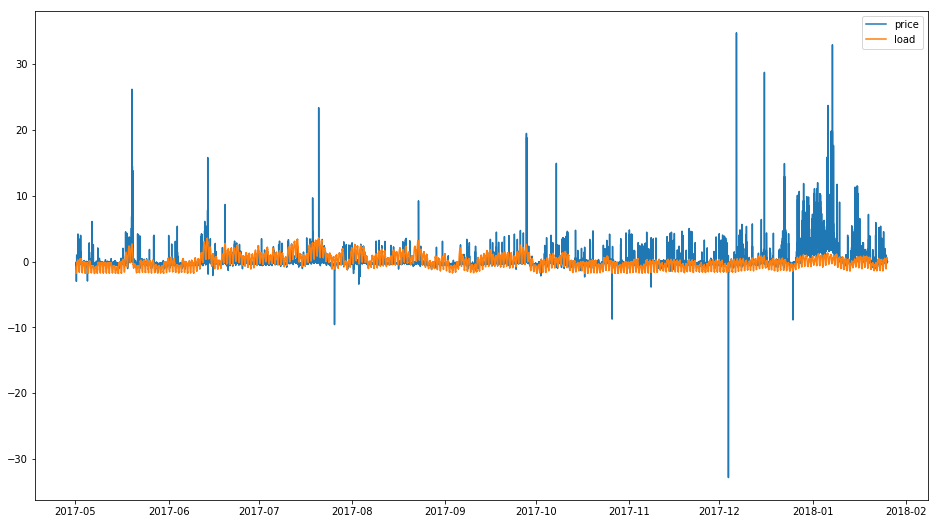

In [71]:
fig, ax = plt.subplots(figsize = (16, 9))
ax.plot(df_price.time_stamp, df_price.lbmp_price_scaled, label = 'price')
ax.plot(df_load.time_stamp, df_load.load_scaled, label = 'load')
ax.legend()

In [72]:
X, Y = feature_target_split(df_load.load_scaled.values, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=False, scale=False)
X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = train_test_ts_split(X, Y, percentage=0.9)

Xp, Yp = feature_target_split(df_price.lbmp_price_scaled.values, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=False, scale=False)
Xp, Yp = np.array(Xp), np.array(Yp)
X_trainp, X_testp, Y_trainp, Y_testp = train_test_ts_split(Xp, Yp, percentage=0.9)

In [73]:
model = Sequential()
model.add(Dense(500, input_shape = (TRAIN_SIZE, )))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(250))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(optimizer='adam', 
              loss='mse')

model.fit(X_train, 
          Y_train, 
          nb_epoch=5, 
          batch_size = 128, 
          verbose=1, 
          validation_split=0.1)
score = model.evaluate(X_test, Y_test, batch_size=128)

/anaconda/envs/py35/lib/python3.5/site-packages/keras/models.py:874: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 63194 samples, validate on 7022 samples
Epoch 1/5
63194/63194 [==============================] - 7s 109us/step - loss: 0.0816 - val_loss: 0.0480
Epoch 2/5
63194/63194 [==============================] - 6s 102us/step - loss: 0.0141 - val_loss: 0.0421
Epoch 3/5
63194/63194 [==============================] - 7s 107us/step - loss: 0.0105 - val_loss: 0.0366
Epoch 4/5
63194/63194 [==============================] - 7s 112us/step - loss: 0.0095 - val_loss: 0.0273
Epoch 5/5
7802/7802 [==============================] - 0s 37us/step


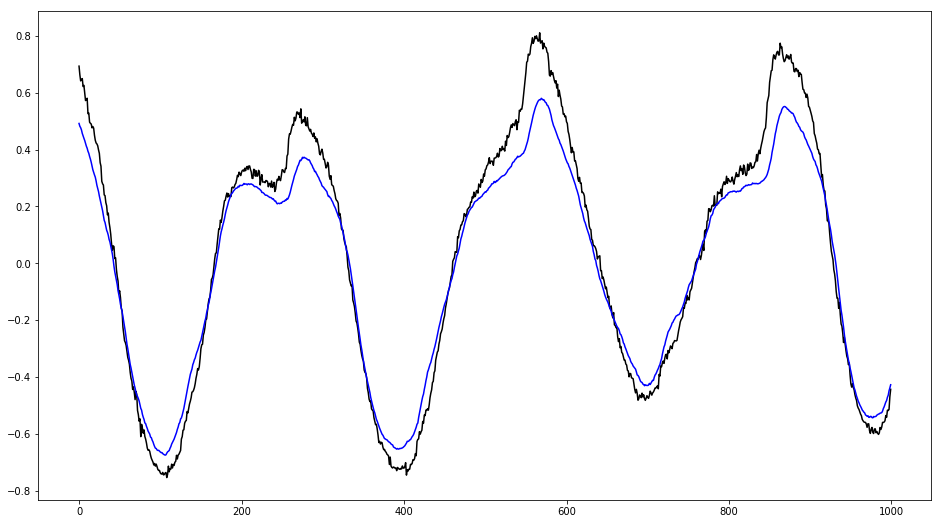

In [74]:
predicted = model.predict(X_test)
try:
    fig = plt.figure(figsize=(16, 9))
    plt.plot(Y_test[:1000], color='black')
    plt.plot(predicted[:1000], color='blue')
    plt.show()
except Exception as e:
    print(str(e))

In [75]:
score

0.015468353180582898

In [76]:
model2 = Sequential()
model2.add(Dense(500, input_shape = (TRAIN_SIZE, )))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(250))
model2.add(Activation('relu'))
model2.add(Dense(1))
model2.add(Activation('linear'))
model2.compile(optimizer='adam', 
              loss='mse')

model2.fit(X_trainp, 
          Y_trainp, 
          nb_epoch=5, 
          batch_size = 128, 
          verbose=1, 
          validation_split=0.1)
score2 = model2.evaluate(X_testp, Y_testp, batch_size=128)

/anaconda/envs/py35/lib/python3.5/site-packages/keras/models.py:874: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 63194 samples, validate on 7022 samples
Epoch 1/5
63194/63194 [==============================] - 7s 109us/step - loss: 0.3419 - val_loss: 0.3086
Epoch 2/5
63194/63194 [==============================] - 7s 109us/step - loss: 0.2744 - val_loss: 0.2699
Epoch 3/5
63194/63194 [==============================] - 7s 118us/step - loss: 0.2640 - val_loss: 0.2868
Epoch 4/5
63194/63194 [==============================] - 7s 114us/step - loss: 0.2544 - val_loss: 0.3155
Epoch 5/5
7802/7802 [==============================] - 0s 50us/step


In [77]:
score2

2.6629627948888057

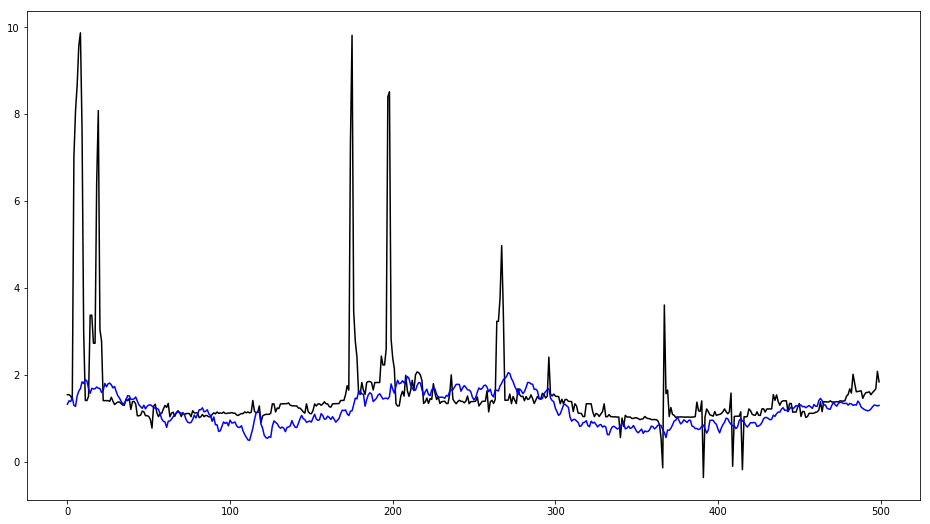

In [79]:
predicted2 = model2.predict(X_testp)
try:
    fig = plt.figure(figsize=(16, 9))
    plt.plot(Y_testp[:500], color='black')
    plt.plot(predicted2[:500], color='blue')
    plt.show()
except Exception as e:
    print(str(e))